# Construction of a QSAR model for Cruzipain inhibitors

## Part 1: Data mining and Exploratory Data Analysis 

Importings:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from chembl_webresource_client.new_client import new_client

Data mining

In [2]:
target = new_client.target
target_query = target.search('cruzipain')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P25779', 'xref_name': None, 'xre...",Trypanosoma cruzi,Cruzipain,21.0,False,CHEMBL3563,"[{'accession': 'P25779', 'component_descriptio...",SINGLE PROTEIN,5693


In [3]:
selected_target = targets.target_chembl_id[0]
selected_target

'CHEMBL3563'

In [4]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type= 'IC50')

In [5]:
df = pd.DataFrame.from_dict(res)
df.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,32722,[],CHEMBL660279,Inhibitory activity against Trypanosoma cruzi ...,B,BAO_0000190,BAO_0000357,single protein format,C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1,...,Trypanosoma cruzi,Cruzipain,5693,None,None,IC50,nM,UO_0000065,None,50.0
1,None,32724,[],CHEMBL660279,Inhibitory activity against Trypanosoma cruzi ...,B,BAO_0000190,BAO_0000357,single protein format,C/C(=N\NC(N)=O)c1cccc(Cl)c1,...,Trypanosoma cruzi,Cruzipain,5693,None,None,IC50,uM,UO_0000065,None,10.0
2,None,33952,[],CHEMBL660279,Inhibitory activity against Trypanosoma cruzi ...,B,BAO_0000190,BAO_0000357,single protein format,CC/C(=N\N=C(/S)NC)c1cccc(Br)c1,...,Trypanosoma cruzi,Cruzipain,5693,None,None,IC50,uM,UO_0000065,None,10.0
3,None,33953,[],CHEMBL660279,Inhibitory activity against Trypanosoma cruzi ...,B,BAO_0000190,BAO_0000357,single protein format,S=C(Nc1cccc(Cl)c1)N1CCC(c2cccc(Br)c2)=N1,...,Trypanosoma cruzi,Cruzipain,5693,None,None,IC50,nM,UO_0000065,None,1000.0
4,None,33955,[],CHEMBL660279,Inhibitory activity against Trypanosoma cruzi ...,B,BAO_0000190,BAO_0000357,single protein format,CCC(N/N=C(/N)S)c1cccc(Br)c1,...,Trypanosoma cruzi,Cruzipain,5693,None,None,IC50,uM,UO_0000065,None,10.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   activity_comment           118 non-null    object
 1   activity_id                840 non-null    int64 
 2   activity_properties        840 non-null    object
 3   assay_chembl_id            840 non-null    object
 4   assay_description          840 non-null    object
 5   assay_type                 840 non-null    object
 6   bao_endpoint               840 non-null    object
 7   bao_format                 840 non-null    object
 8   bao_label                  840 non-null    object
 9   canonical_smiles           840 non-null    object
 10  data_validity_comment      86 non-null     object
 11  data_validity_description  86 non-null     object
 12  document_chembl_id         840 non-null    object
 13  document_journal           840 non-null    object
 14  document_y

The dataset contains 840 compounds that inhibit CZP and 40 features.

In [7]:
df.standard_type.unique()

array(['IC50'], dtype=object)

In [8]:
df.standard_units.unique()

array(['nM', None], dtype=object)

In [9]:
df.standard_value.isna().sum()

118

Biological activity assays results are expresed as IC50 and 'nM' as unique unit.

In [10]:
duplicated_compounds = df.duplicated(subset='molecule_chembl_id', keep='first').sum()
print('There are', duplicated_compounds, 'duplicated compounds')

There are 191 duplicated compounds


In [11]:
#Duplicated compounds are eliminated
df.drop_duplicates(subset=['molecule_chembl_id'], inplace=True)

In [12]:
print('Total number of compounds:', len(df))

Total number of compounds: 649


In [13]:
#Dtype correction for standard_value feature
df['standard_value'] = df['standard_value'].apply(pd.to_numeric)

In [14]:
nulos = df['standard_value'].isnull().sum()
print('There are', nulos, 'compounds without bioactivity value')

There are 103 compounds without bioactivity value


In [15]:
#We select those compounds with bioactivity data informed
df2 = df[df.standard_value.notna()]
df2 = df2.reset_index(drop=True)

In [16]:
#We select those features that are important for our objective
selection = ['molecule_chembl_id', 'canonical_smiles', 'standard_value']
df3 = df2[selection]
df3 = df3.reset_index(drop=True)

In [17]:
df3.head()

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL90512,C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1,50.0
1,CHEMBL327902,C/C(=N\NC(N)=O)c1cccc(Cl)c1,10000.0
2,CHEMBL88307,CC/C(=N\N=C(/S)NC)c1cccc(Br)c1,10000.0
3,CHEMBL90475,S=C(Nc1cccc(Cl)c1)N1CCC(c2cccc(Br)c2)=N1,1000.0
4,CHEMBL90371,CCC(N/N=C(/N)S)c1cccc(Br)c1,10000.0


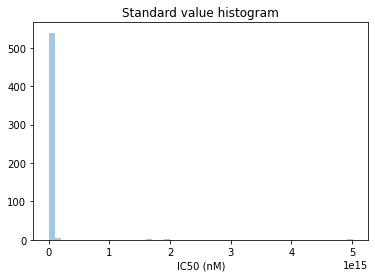

In [41]:
#Histogram
sns.distplot(df3['standard_value'], kde=False)
plt.title('Standard value histogram')
plt.xlabel('IC50 (nM)')
plt.savefig('histogramczinhibidores.png')
plt.show()

In [19]:
df3.standard_value.describe()

count    5.460000e+02
mean     1.787761e+13
std      2.416714e+14
min      1.000000e-01
25%      6.475000e+02
50%      1.000000e+04
75%      4.075000e+04
max      5.011872e+15
Name: standard_value, dtype: float64

In [20]:
#Compound classification 
bioactivity_class = []
for i in df2.standard_value:
  if float(i) > 10000:
    bioactivity_class.append("inactive")
  elif float(i) <= 10000:
    bioactivity_class.append("active")

In [21]:
df3['bioactivity_class'] = bioactivity_class

In [22]:
df3.head()

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL90512,C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1,50.0,active
1,CHEMBL327902,C/C(=N\NC(N)=O)c1cccc(Cl)c1,10000.0,active
2,CHEMBL88307,CC/C(=N\N=C(/S)NC)c1cccc(Br)c1,10000.0,active
3,CHEMBL90475,S=C(Nc1cccc(Cl)c1)N1CCC(c2cccc(Br)c2)=N1,1000.0,active
4,CHEMBL90371,CCC(N/N=C(/N)S)c1cccc(Br)c1,10000.0,active


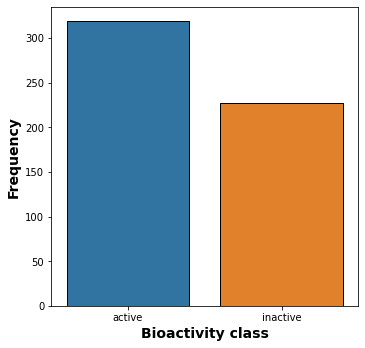

In [43]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df3, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.savefig('plot_bioactivity_class_cz.png')

In [24]:
df3.groupby('bioactivity_class').count()

,molecule_chembl_id,canonical_smiles,standard_value
bioactivity_class,,,
active,319,319,319
inactive,227,227,227


In [25]:
total = 319+227
a = (319/total)*100
i = (227/total)*100
print('Porcentaje de moléculas activas:',round(a,2))
print('Porcentaje de moléculas inactivas:', round(i,2))
print('Total de compuestos:', total)

Porcentaje de moléculas activas: 58.42
Porcentaje de moléculas inactivas: 41.58
Total de compuestos: 546


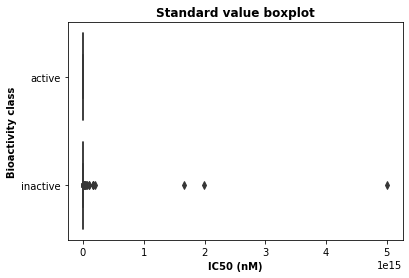

In [46]:
#Boxplot
sns.boxplot(data = df3, x= 'standard_value', y='bioactivity_class', palette='colorblind')
plt.title('Standard value boxplot', fontweight='bold')
plt.xlabel('IC50 (nM)', fontweight='bold')
plt.ylabel('Bioactivity class', fontweight='bold')
plt.savefig('boxplotinhibidorescz.png')
plt.show()

In [27]:
#Normalizar
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [28]:
df4 = norm_value(df3)

In [29]:
#Outliers

def remove_outliers(dfx):
    q1 = dfx.quantile(0.25)
    q3 = dfx.quantile(0.75)
    iqr = q3 - q1
    cut_off = iqr*1.5
    
    df_filtred = dfx[~((dfx < (dfx.quantile(0.25) - cut_off)) | (dfx > (dfx.quantile(0.75) + cut_off))).any(axis=1)]
       
    return df_filtred

In [30]:
#df4 = remove_outliers(df3)

Text(0, 0.5, 'Bioactivity class')

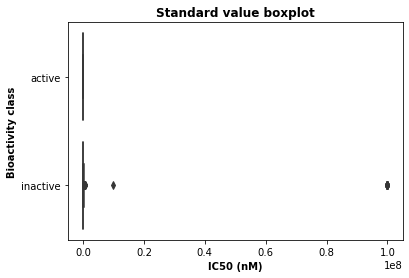

In [31]:
#Boxplot
sns.boxplot(data = df4, x= 'standard_value_norm', y='bioactivity_class', palette='colorblind')
plt.title('Standard value boxplot', fontweight='bold')
plt.xlabel('IC50 (nM)', fontweight='bold')
plt.ylabel('Bioactivity class', fontweight='bold')
plt.savefig('boxplotnormalizado.png')
plt.show()

In [32]:
df4.describe()

,standard_value_norm
count,5.460000e+02
mean,2.982352e+06
std,1.687772e+07
min,1.000000e-01
25%,6.475000e+02
50%,1.000000e+04
75%,4.075000e+04
max,1.000000e+08


In [33]:
df4.to_csv('CZP_bioactivity_preprocessed_data.csv', index=False)

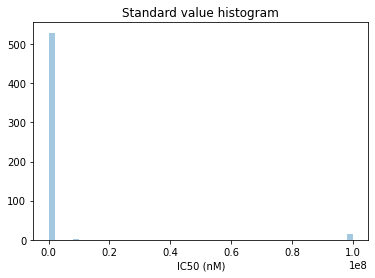

In [45]:
#Histogram
sns.distplot(df4['standard_value_norm'], kde=False)
plt.title('Standard value histogram')
plt.xlabel('IC50 (nM)')
plt.savefig('histograma_raw.png')

# PubChem Database

In [35]:
pubchem = pd.read_csv(r'/home/seba/Documentos/Postdoc/databases/PubChem/CompuestosCruzipaina_PubchemDB.csv')

In [36]:
pubchem.head()

,baid,activity,aid,sid,mid,cid,geneid,taxid,pmid,aidtype,...,acname,acvalue,aidsrcname,aidname,cmpdname,targetname,targeturl,dois,ecs,repacxn
0,97465927,Active,51390,103300887,0,9965377,NaN,5693,12061873.0,Confirmatory,...,IC50,0.05,ChEMBL,Inhibitory activity against Trypanosoma cruzi ...,[(E)-1-[3-(Trifluoromethyl)phenyl]propylidenea...,Cruzipain (Trypanosoma cruzi),/protein/P25779,10.1021/jm010459j,3.4.22.51,P25779
1,97465930,Active,51390,103300978,0,9580972,NaN,5693,12061873.0,Confirmatory,...,IC50,0.48,ChEMBL,Inhibitory activity against Trypanosoma cruzi ...,(2E)-2-[3-(Trifluoromethyl)benzylidene]hydrazi...,Cruzipain (Trypanosoma cruzi),/protein/P25779,10.1021/jm010459j,3.4.22.51,P25779
2,97465934,Active,51390,103301266,0,9971885,NaN,5693,12061873.0,Confirmatory,...,IC50,0.08,ChEMBL,Inhibitory activity against Trypanosoma cruzi ...,3-(3-Bromophenyl)-4-methyl-2-pyrazoline-1-thio...,Cruzipain (Trypanosoma cruzi),/protein/P25779,10.1021/jm010459j,3.4.22.51,P25779
3,97465935,Active,51390,103301291,0,5412428,NaN,5693,12061873.0,Confirmatory,...,IC50,3.80,ChEMBL,Inhibitory activity against Trypanosoma cruzi ...,[(E)-1-(5-Bromothiophen-2-yl)ethylideneamino]t...,Cruzipain (Trypanosoma cruzi),/protein/P25779,10.1021/jm010459j,3.4.22.51,P25779
4,97465937,Active,51390,103301423,0,6875577,NaN,5693,12061873.0,Confirmatory,...,IC50,0.56,ChEMBL,Inhibitory activity against Trypanosoma cruzi ...,2-Methoxy-1-naphthaldehyde thiosemicarbazone,Cruzipain (Trypanosoma cruzi),/protein/P25779,10.1021/jm010459j,3.4.22.51,P25779


Text(0, 0.5, 'Frequency')

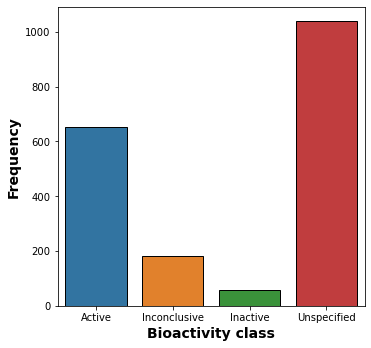

In [37]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='activity', data=pubchem, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
#plt.savefig('plot_bioactivity_class.png')

In [38]:
df_pubchem = pubchem[['baid','activity', 'acname', 'acvalue']]

In [39]:
mask = (pubchem.activity == 'Unspecified')

In [40]:
pubchem[mask]

,baid,activity,aid,sid,mid,cid,geneid,taxid,pmid,aidtype,...,acname,acvalue,aidsrcname,aidname,cmpdname,targetname,targeturl,dois,ecs,repacxn
888,97465923,Unspecified,51390,103300471,0,10989825,NaN,5693,12061873.0,Confirmatory,...,IC50,10.0,ChEMBL,Inhibitory activity against Trypanosoma cruzi ...,[(E)-1-(6-Methoxynaphthalen-2-yl)propylideneam...,Cruzipain (Trypanosoma cruzi),/protein/P25779,10.1021/jm010459j,3.4.22.51,P25779
889,97465924,Unspecified,51390,103300614,0,10870240,NaN,5693,12061873.0,Confirmatory,...,IC50,10.0,ChEMBL,Inhibitory activity against Trypanosoma cruzi ...,"5-(3-Bromophenyl)-N-methyl-3,4-dihydropyrazole...",Cruzipain (Trypanosoma cruzi),/protein/P25779,10.1021/jm010459j,3.4.22.51,P25779
890,97465926,Unspecified,51390,103300644,0,11068551,NaN,5693,12061873.0,Confirmatory,...,IC50,10.0,ChEMBL,Inhibitory activity against Trypanosoma cruzi ...,1-[(E)-1-(3-Bromophenyl)propylideneamino]-3-(f...,Cruzipain (Trypanosoma cruzi),/protein/P25779,10.1021/jm010459j,3.4.22.51,P25779
891,97465928,Unspecified,51390,103300921,0,9563572,NaN,5693,12061873.0,Confirmatory,...,IC50,10.0,ChEMBL,Inhibitory activity against Trypanosoma cruzi ...,({[5-(4-Chlorophenyl)furan-2-yl]methylidene}am...,Cruzipain (Trypanosoma cruzi),/protein/P25779,10.1021/jm010459j,3.4.22.51,P25779
892,97465929,Unspecified,51390,103300939,0,11064119,NaN,5693,12061873.0,Confirmatory,...,IC50,10.0,ChEMBL,Inhibitory activity against Trypanosoma cruzi ...,[(E)-1-(3-Chlorophenyl)propylideneamino]urea,Cruzipain (Trypanosoma cruzi),/protein/P25779,10.1021/jm010459j,3.4.22.51,P25779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1922,460857598,Unspecified,1508566,404656443,0,145952609,NaN,5693,29031078.0,Literature-derived,...,NaN,NaN,ChEMBL,Inhibition of recombinant Trypanosoma cruzi cr...,"N-[(E)-1-(3,4-Dichlorophenyl)ethylideneamino]-...",Cruzipain (Trypanosoma cruzi),/protein/P25779,10.1016/j.ejmech.2017.09.047,3.4.22.51,P25779
1923,460857601,Unspecified,1508566,404667233,0,145960071,NaN,5693,29031078.0,Literature-derived,...,NaN,NaN,ChEMBL,Inhibition of recombinant Trypanosoma cruzi cr...,"N-[(E)-1-(3,4-Dichlorophenyl)ethylideneamino]-...",Cruzipain (Trypanosoma cruzi),/protein/P25779,10.1016/j.ejmech.2017.09.047,3.4.22.51,P25779
1924,460857603,Unspecified,1508566,404663044,0,145957153,NaN,5693,29031078.0,Literature-derived,...,NaN,NaN,ChEMBL,Inhibition of recombinant Trypanosoma cruzi cr...,"N-[(E)-1-(3,4-Dichlorophenyl)ethylideneamino]-...",Cruzipain (Trypanosoma cruzi),/protein/P25779,10.1016/j.ejmech.2017.09.047,3.4.22.51,P25779
1925,460857605,Unspecified,1508566,404683775,0,145971226,NaN,5693,29031078.0,Literature-derived,...,NaN,NaN,ChEMBL,Inhibition of recombinant Trypanosoma cruzi cr...,"N-[(E)-1-(3,4-Dichlorophenyl)ethylideneamino]-...",Cruzipain (Trypanosoma cruzi),/protein/P25779,10.1016/j.ejmech.2017.09.047,3.4.22.51,P25779
